# Diffusion Curves

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import triangle as tr

## Create / Load Data
- A geometric curve : cubic Bezier Spline
- Several colors on both sides

In [30]:
# x-y range of the image
xmax = 2.0
xmin = 0.0
ymax = 2.0
ymin = 0.0
vmin = np.array([xmin, ymin])
vmax = np.array([xmax, ymax])
xrange = xmax - xmin
yrange = ymax - ymin
# distance of left/right color curve to original curve
small_dist = xrange/50 

### Bezier Curve

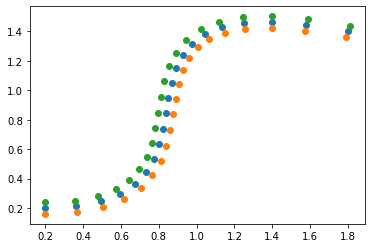

In [31]:
def cubic_bezier(_t, _v0, _v1, _v2, _v3):
    point = pow(1-_t, 3)*_v0 + 3*(1-_t)*(1-_t)*_t*_v1 + 3*(1-_t)*_t*_t*_v2 + pow(_t,3)*_v3
    derivative = 3*(1-_t)*(1-_t)*(_v1-_v0) + 6*(1-_t)*_t*(_v2-_v1) + 3*_t*_t*(_v3-_v2)
    # normalize
    tangent = derivative / np.linalg.norm(derivative)
    # rotate by 90 clockwise
    # (x,y) -> (-y, x)
    normal = np.array([-tangent[1], tangent[0]])   
    return point, normal
    
# def create_cubic_bezier_spline_data():
#     v0 = vmin + np.array([dx*0.1, dy*0.1])
#     v1 = vmin + np.array([dx*0.7, dy*0.1])
#     v2 = vmin + np.array([dx*0.1, dy*0.9])
#     v3 = vmin + np.array([dx*0.9, dy*0.7])
# #     vs = np.array([v0, v1, v2, v3])
# #     plt.plot(vs[:,0],vs[:,1])
#     vertices = []
#     for i in range(20):
#         vertices.append(cubic_bezier(i/20.0, v0, v1, v2, v3))
#     vertices = np.array(vertices)
#     plt.scatter(vertices[:,0],vertices[:,1])
# create_cubic_bezier_spline_data()

v0 = vmin + np.array([xrange*0.1, yrange*0.1])
v1 = vmin + np.array([xrange*0.7, yrange*0.1])
v2 = vmin + np.array([xrange*0.1, yrange*0.9])
v3 = vmin + np.array([xrange*0.9, yrange*0.7])
curve_vertices = []
# left/right curves (color sources)
curve_left_vertices = []
curve_right_vertices = []
sample_num = 21
# delta t
sample_interval = 1/float(sample_num-1)
for i in range(sample_num):
    v, norm = cubic_bezier(i*sample_interval, v0, v1, v2, v3)
    v_left = v - small_dist * norm
    v_right = v + small_dist * norm
    curve_vertices.append(v)
    curve_left_vertices.append(v_left)
    curve_right_vertices.append(v_right)
    
curve_vertices = np.array(curve_vertices)
curve_left_vertices = np.array(curve_left_vertices)
curve_right_vertices = np.array(curve_right_vertices)
plt.scatter(curve_vertices[:,0],curve_vertices[:,1])
plt.scatter(curve_left_vertices[:,0],curve_left_vertices[:,1])
plt.scatter(curve_right_vertices[:,0],curve_right_vertices[:,1])

### Color Sources

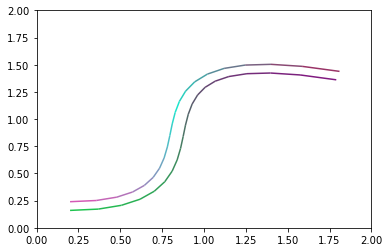

In [68]:
# color constraints on the left, each element is [r,g,b,t]
# assume intervals (t1-t2) of any two constraints is greater than sample integrals
cls_raw = np.array([[0.1,0.8,0.3,0.0],[0.5,0.1,0.5,1.0]])
crs_raw = np.array([[0.9,0.3,0.7,0.0],[0.1,0.9,0.8,0.6],[0.6,0.2,0.4,1.0]])
cls_raw_colors = cls_raw[:,:3]
crs_raw_colors = crs_raw[:,:3]
cls_raw_ts = cls_raw[:,3]
crs_raw_ts = crs_raw[:,3]

# interpolate to get colors of sample points
# two iterators on raw colors
def get_sample_colors(_raw_colors, _raw_ts):
    raw_num = _raw_colors.shape[0]
    raw_i = 0
    raw_j = 1
    raw_ti = _raw_ts[raw_i]
    raw_tj = _raw_ts[raw_j]
    sample_colors = []
    for i in range(sample_num):
        t = i*sample_interval
        # t should be between ti and tj
        if(t>raw_tj - 0.0001 and raw_j < raw_num - 1):
            raw_j += 1
            raw_tj = _raw_ts[raw_j]
            raw_i += 1
            raw_ti = _raw_ts[raw_i]
        dti = t - raw_ti
        dtj = raw_tj - t
        x = dti/(dti+dtj)
        color = x*_raw_colors[raw_j] + (1-x)*_raw_colors[raw_i]
        sample_colors.append(color)
    return np.array(sample_colors)
        
curve_left_colors = get_sample_colors(cls_raw_colors, cls_raw_ts)
curve_right_colors = get_sample_colors(crs_raw_colors, crs_raw_ts)
curve_left_vertices_reshaped = curve_left_vertices.reshape(-1,1,2)
curve_left_segments = np.concatenate([curve_left_vertices_reshaped[:-1], curve_left_vertices_reshaped[1:]], axis=1)
curve_right_vertices_reshaped = curve_right_vertices.reshape(-1,1,2)
curve_right_segments = np.concatenate([curve_right_vertices_reshaped[:-1], curve_right_vertices_reshaped[1:]], axis=1)
fig, ax = plt.subplots()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
curve_left_segments = LineCollection(curve_left_segments, colors=curve_left_colors[1:,:], linestyle='solid')
curve_right_segments = LineCollection(curve_right_segments, colors=curve_right_colors[1:,:], linestyle='solid')
ax.add_collection(curve_left_segments)
ax.add_collection(curve_right_segments)
# plt.scatter(curve_left_vertices[:,0],curve_left_vertices[:,1], c = curve_left_colors)
# plt.plot(curve_right_vertices[:,0],curve_right_vertices[:,1], color = curve_right_colors)    

### Gradients

## Triangle Meshes

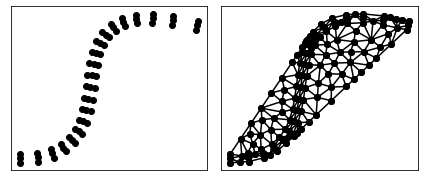

In [69]:
# A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
A = dict(vertices=np.concatenate((curve_vertices, curve_left_vertices, curve_right_vertices),axis=0))
B = tr.triangulate(A, 'qa0.01')
tr.compare(plt, A, B)
plt.show()